# Surprisal/Shannon Information

The [**Shannon information,**](https://en.wikipedia.org/wiki/Information_content) also called the **self-information,** **information content,** or **surprisal** was invented by Claude Shannon as a way to create a monotonically decreasing function of probability.

That is, as a probability becomes larger, the Shannon information becomes smaller, and vice versa.

The intuitive idea behind this measurement is that an unlikely event is more *surprising* and therefore *\"contains more information,\"* while a likely event is *obvious* and *\"contains less information.\"*

## Definition

Shannon defined surprisal as follows:

$$ \text{I}(X=x) := -\log[\text{Pr}(X=x)] = \log\left(\frac{1}{\text{Pr}(X=x)}\right) $$

where $\text{Pr}$ means "probability of," $X$ is a discrete random variable, and $x$ is some particular outcome of the random variable $X$.

Note that the rules of logarithms allow either of the two expressions (negative log probability or log of reciprocal of probability) - they are equivalent.

## Some motivation behind the definition

Let's say we learn not one, but two pieces of information, which are independent of each other.

Shouldn't the total information gained be the sum of the information contents of the two events?

Well, if we have two independent events $x$ and $y$ (observed instances of random variables $X$ and $Y$), we know that:

$$ \text{Pr}(X=x, Y=y) = \text{Pr}(X=x) \cdot \text{Pr}(Y=y) $$

If we take the logarithm of both sides (and simplify the notation a bit):

$$ \log\bigg(\text{Pr}(x, y)\bigg) = \log\bigg(\text{Pr}(x) \cdot \text{Pr}(y)\bigg) $$

Applying a rule of logarithms:

$$ \log\bigg(\text{Pr}(x, y)\bigg) = \log\bigg(\text{Pr}(x)\bigg) + \log\bigg(\text{Pr}(y)\bigg) $$

Now an issue is that the logarithm of a number strictly between 0 and 1 (i.e. all valid probabilities besides 0 and 1) is negative. Since positive numbers are more friendly, we'll just take the negative of both sides:

$$ -\log\bigg(\text{Pr}(x, y)\bigg) = -\log\bigg(\text{Pr}(x)\bigg) - \log\bigg(\text{Pr}(y)\bigg) $$

And that is the (non-negative) information content of two independent observations $x$ and $y$!

Something great about this definition is that it agrees intuitively with the "surprising" vs. "obvious" we were talking about.

Consider an event whose probability is exactly 1 - we are certain the event will occur. This is completely obvious, and thus the information gained from observing it is 0:

$$ -\log(1) = \log\left(\frac{1}{1}\right) = \log(1) = 0 $$

Now consider an event whose probability approaches 0 - we are nearly certain the event will NOT occur. As such, observing this event is extremely surprising, and the information gained from observing it is substantial:

$$ \lim_{\text{Pr}(x)\to0^+}-\log(\text{Pr}(x)) = \lim_{\text{Pr}(x)\to0^+}\log\left(\frac{1}{\text{Pr}(x)}\right) ``=" \infty $$

That is, for events with very small probabilities, the information gained from observing them approaches infinity. You can keep testing smaller and smaller probabilities, and you will find that the information gained from observing events with such probabilities **increases without bound.**

## Visual proof of logarithm rules

In case you don't believe the logarithm rules, [here](https://www.desmos.com/3d/iaoxsiclni) are some graphs I made. You can click the colored buttons on the left-hand side to show/hide the different graphs.

## Numpy Implementation

Here are some simple implementation(s) of Shannon information (computed for each element in the list provided).

The choice of base (2, $e$, or 10) affects the "units" of the information gained. When using base 2, the unit of information gain is called a **shannon.** For base $e$, it is a **nat,** and for base 10, it is a **hartley.**

In [ ]:
from numpy import log2, array

def info(probs):
    return -log2(array(probs))

def also_info(probs):
    return log2(1 / array(probs))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

probs = [1, 1/2, 1/32, 1/32768, 1/1073741824]

df = pd.DataFrame({
    'probs': probs,
    'info': info(probs),
    'also_info': also_info(probs)
})

df

,probs,info,also_info
0,1.000000e+00,-0.0,0.0
1,5.000000e-01,1.0,1.0
2,3.125000e-02,5.0,5.0
3,3.051758e-05,15.0,15.0
4,9.313226e-10,30.0,30.0


## Computing GPT-2's surprisal over a few sequences

[GPT-2](https://insightcivic.s3.us-east-1.amazonaws.com/language-models.pdf) is a generative, decoder-only/autoregressive LM. As such, we can compute surprisal at each time step by just feeding the sequence into the model and taking a softmax over the logits produced at each time step.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# load GPT2 and its tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model.eval()

def gpt_surprisal(sentence, num):

    # tokenize sentence into a torch tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    input_ids = inputs['input_ids']

    # pass token sequence through model
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    # softmax over the vocabulary dimension of the outputs
    softmax = torch.nn.functional.softmax(logits, dim=-1)

    df = pd.DataFrame(columns=['Word', 'Surprisal'])

    for i in range(input_ids.size(1)):

        # i-th word's token ID in our token sequence
        word_id = input_ids[0, i].item()

        # probability assigned to the next word given the preceding context
        word_prob = softmax[0, i-1, word_id]

        # torch implementation of surprisal
        surprisal = -torch.log2(word_prob)

        # get the string representation of the word back again
        word = tokenizer.decode([word_id])

        # record model's surprisal for this word
        df.loc[len(df)] = [word, surprisal.item()]

    plt.subplot(1, 4, num)
    plt.plot(df['Surprisal'], marker='.')
    plt.xticks(ticks=range(len(df)), labels=df['Word'], rotation=75)
    plt.yticks(ticks=range(0, 25, 2))
    plt.grid()
    plt.title('...' + sentence.split()[-1][:-1])
    plt.xlabel('Word')
    plt.ylabel('Surprisal (bits)')

    print(df)
    print('\n\n')

     Word  Surprisal
0     The  11.515247
1   quick  12.569285
2   brown  12.846174
3     fox   9.033365
4   jumps   7.005925
5    over   3.964449
6     the   1.242004
7    lazy  10.458130
8     dog   5.507222
9       .   3.469889



         Word  Surprisal
0         The  11.760910
1       quick  12.569285
2       brown  12.846174
3         fox   9.033365
4       jumps   7.005925
5        over   3.964449
6         the   1.242004
7        lazy  10.458130
8   corrosion  20.361404
9           .   5.036672



     Word  Surprisal
0     The  10.904498
1   quick  12.569285
2   brown  12.846174
3     fox   9.033365
4   jumps   7.005925
5    over   3.964449
6     the   1.242004
7    lazy  10.458130
8      of  11.482301
9       .  13.755733



      Word  Surprisal
0      The  12.224914
1    quick  12.569285
2    brown  12.846174
3      fox   9.033365
4    jumps   7.005925
5     over   3.964449
6      the   1.242004
7     lazy  10.458130
8      per  13.856256
9       ro  10.085133
10       .  

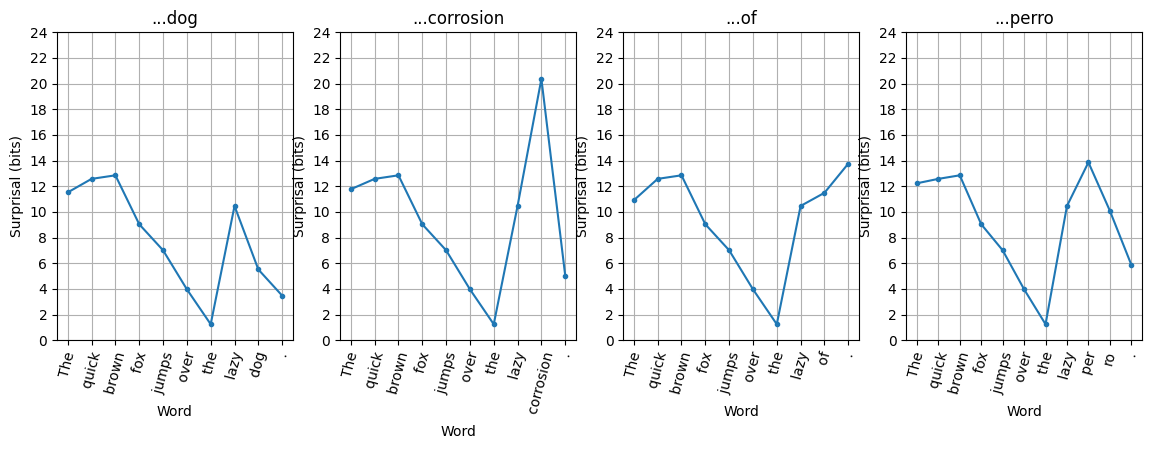

In [ ]:
plt.figure(figsize=(14, 4))
plt.tight_layout()
gpt_surprisal("The quick brown fox jumps over the lazy dog.", 1)
gpt_surprisal("The quick brown fox jumps over the lazy corrosion.", 2)
gpt_surprisal("The quick brown fox jumps over the lazy of.", 3)
gpt_surprisal("The quick brown fox jumps over the lazy perro.", 4)
plt.show()

## Computing BERT's surprisal over a few sequences

[BERT](https://arxiv.org/pdf/1810.04805) is a discriminative, encoder-only/masked LM. As such, we can compute surprisal at each time step by masking out each token, one at a time, and taking a softmax over the logits produced at the masked time step.

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# load GPT2 and its tokenizer
model_name = "bert-base-uncased"
model = BertForMaskedLM.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.eval()

def bert_surprisal(sentence, num):

    # tokenize sentence into a torch tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    input_ids = inputs['input_ids']

    df = pd.DataFrame(columns=['Word', 'Surprisal'])

    for i in range(1, input_ids.size(1) - 1):

        # mask a token
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, i] = tokenizer.mask_token_id

        with torch.no_grad():
            outputs = model(masked_input_ids)
            logits = outputs.logits

        # softmax over the vocabulary dimension of the outputs
        # restrict to current token to save a bit of compute
        softmax = torch.nn.functional.softmax(logits[0, i], dim=-1)

        # i-th word's token ID in our token sequence
        word_id = input_ids[0, i].item()

        # probability assigned to the next word given the preceding context
        word_prob = softmax[word_id]

        # torch implementation of surprisal
        surprisal = -torch.log2(word_prob)

        # get the string representation of the word back again
        word = tokenizer.decode([word_id])

        # record model's surprisal for this word
        df.loc[len(df)] = [word, surprisal.item()]

    plt.subplot(1, 4, num)
    plt.plot(df['Surprisal'], marker='.')
    plt.xticks(ticks=range(len(df)), labels=df['Word'], rotation=75)
    plt.yticks(ticks=range(0, 25, 2))
    plt.grid()
    plt.title('...' + sentence.split()[-1][:-1])
    plt.xlabel('Word')
    plt.ylabel('Surprisal (bits)')

    print(df)
    print('\n\n')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

    Word  Surprisal
0    the   2.023805
1  quick  16.252876
2  brown   7.069637
3    fox   6.454727
4  jumps   9.147576
5   over   4.555429
6    the   0.270861
7   lazy   9.540740
8    dog   7.727890
9      .   0.029186



        Word  Surprisal
0        the   3.166567
1      quick  15.813137
2      brown   7.115977
3        fox   7.785974
4      jumps  10.516623
5       over   3.302011
6        the   0.180716
7       lazy  13.221563
8  corrosion  20.197496
9          .   0.023570



    Word  Surprisal
0    the   2.915595
1  quick  15.318842
2  brown   7.797453
3    fox   9.323949
4  jumps   9.435369
5   over   6.029814
6    the   0.941009
7   lazy  19.864281
8     of  15.490071
9      .   0.126935



     Word  Surprisal
0     the   2.107799
1   quick  15.464625
2   brown   6.714638
3     fox   6.556977
4   jumps   9.226710
5    over   3.212595
6     the   0.298618
7    lazy  10.006995
8     per   9.213134
9    ##ro  13.693546
10      .   0.047083





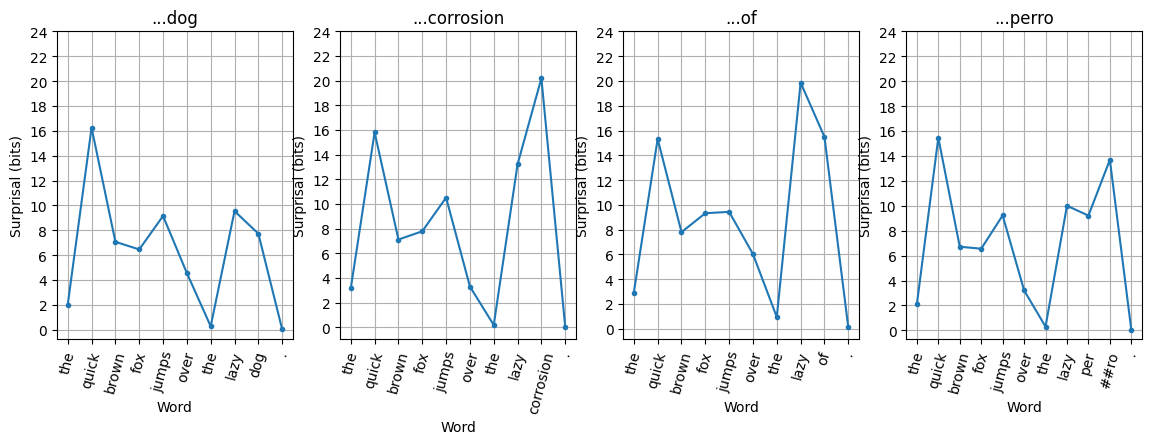

In [ ]:
plt.figure(figsize=(14, 4))
plt.tight_layout()
bert_surprisal("The quick brown fox jumps over the lazy dog.", 1)
bert_surprisal("The quick brown fox jumps over the lazy corrosion.", 2)
bert_surprisal("The quick brown fox jumps over the lazy of.", 3)
bert_surprisal("The quick brown fox jumps over the lazy perro.", 4)
plt.show()

## Character Surprisal

Cleaning up the Brown corpus doesn't give us exactly what we expect, but it gives some interesting insights.

In [ ]:
from string import punctuation
import nltk
nltk.download('brown')
from nltk.corpus import brown
import re

text = ''

pos_tag_regex = r'/[`\'\$A-Za-z\-\.]* '
white_space_not_space_char_regex = r'[\n\t\r]'

for fileid in brown.fileids():
    text += re.sub(pos_tag_regex, ' ', brown.raw(fileid))

text = re.sub(white_space_not_space_char_regex, '', text)

punctuation = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

digits = '0123456789'

for char in digits:
    text = text.replace(char, '')

for char in punctuation:
    text = text.replace(char, '')

text = text.replace(' -', ' ')
text = text.replace(' - ', ' ')
text = text.replace('- ', ' ')
text = text.replace('-', ' ')

while '  ' in text:
    text = text.replace('  ', ' ')

text = text.lower().strip()

text[:1000]

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


'the fulton county grand jury said friday an investigation of atlantas recent primary election produced no evidence that any irregularities took place the jury further said in term end presentments that the city executive committee which had over all charge of the election deserves the praise and thanks of the city of atlanta for the manner in which the election was conducted the september october term jury had been charged by fulton superior court judge durwood pye to investigate reports of possible irregularities in the hard fought primary which was won by mayor nominate ivan allen jr only a relative handful of such reports was received the jury said considering the widespread interest in the election the number of voters and the size of this city the jury said it did find that many of georgias registration and election laws are outmoded or inadequate and often ambiguous it recommended that fulton legislators act to have these laws studied and revised to the end of modernizing and im

Below, we build a vector of unigram counts and a matrix of bigram counts.

In [ ]:
import string
import numpy as np

mapping = {
    c: i for i, c in enumerate(' ' + string.ascii_lowercase)
}

unigram_char_count_vector = np.array([0] * len(mapping))
bigram_char_count_matrix = np.array([[0] * len(mapping)] * len(mapping))

for i in range(len(text) - 1):
    unigram_char_count_vector[mapping[text[i]]] += 1
    bigram_char_count_matrix[mapping[text[i]], mapping[text[i + 1]]] += 1
unigram_char_count_vector[mapping[text[-1]]] += 1

## Heatmaps for unigrams

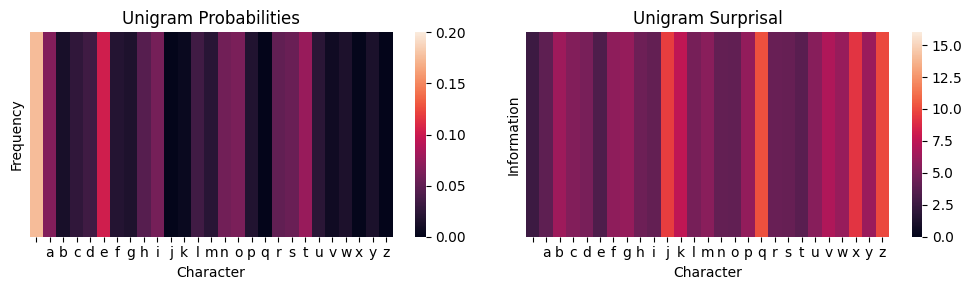

In [ ]:
from seaborn import heatmap

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

normed_vector = unigram_char_count_vector / sum(unigram_char_count_vector)

heatmap(
    [normed_vector],
    xticklabels=list(mapping.keys()),
    yticklabels=[],
    ax=ax1,
    vmin=0,
    vmax=0.2
)
ax1.set_title('Unigram Probabilities')
ax1.set_xlabel('Character')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

heatmap(
    [info(normed_vector)],
    xticklabels=list(mapping.keys()),
    yticklabels=[],
    ax=ax2,
    vmin=0,
    vmax=16
)
ax2.set_title('Unigram Surprisal')
ax2.set_xlabel('Character')
ax2.set_ylabel('Information')
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## Heatmaps for bigrams

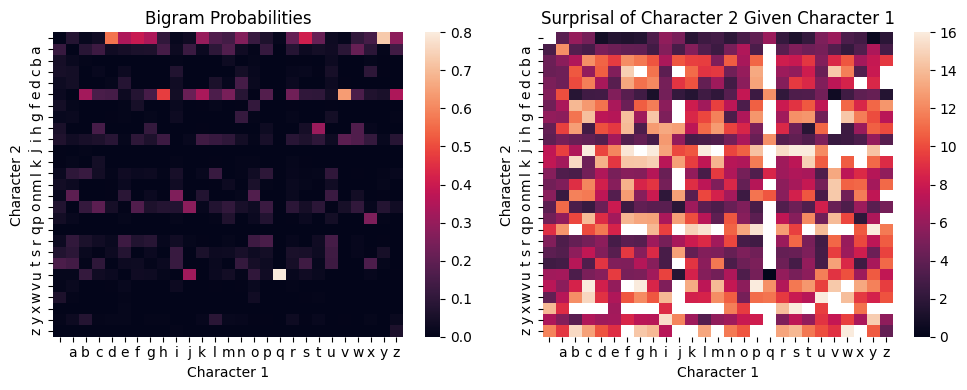

In [ ]:
from seaborn import heatmap

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 4))

normed_matrix = bigram_char_count_matrix / bigram_char_count_matrix.sum(axis=1, keepdims=True)

heatmap(
    normed_matrix.transpose(),
    xticklabels=list(mapping.keys()),
    yticklabels=list(mapping.keys()),
    ax=ax3,
    vmin=0,
    vmax=0.8
)
ax3.set_title('Bigram Probabilities')
ax3.set_xlabel('Character 1')
ax3.set_ylabel('Character 2')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

heatmap(
    info(normed_matrix.transpose()),
    xticklabels=list(mapping.keys()),
    yticklabels=list(mapping.keys()),
    ax=ax4,
    vmin=0,
    vmax=16
)
ax4.set_title('Surprisal of Character 2 Given Character 1')
ax4.set_xlabel('Character 1')
ax4.set_ylabel('Character 2')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()